- Nguồn tham khảo: [Github Project](https://github.com/hknakst/Detection-of-copy-move-forgery)
- Tác giả: [Github Profile](https://github.com/hknakst)

### Phương pháp được sử dụng
Mã nguồn này xác định ảnh giả mạo Copy-Move nhờ vào so sánh các block của ảnh (Robust Match).

- Ở hàm `dct_of_img`, ảnh được chia nhỏ ra các block với kích thước các block là như nhau $(B \times B)$, với mỗi block, phép biến đổi DCT được áp dụng và lưu kết quả các hệ số của DCT vào ma trận kết quả A (hàm`zigzag`).
- Ma trận kết quả A sẽ có $(M-B+1)(N-B+1)$ dòng và $(B \times B)$ cột.

![blocks](blocks.png)

- Công thức của DCT khi áp dụng vào ảnh 2 chiều:
$$F(u) = (\dfrac{2}{N})^{\frac{1}{2}}(\dfrac{2}{M})^{\frac{1}{2}}\sum_{i=1}^{N-1}\sum_{i=1}^{M-1}\Lambda(i).\Lambda(j).cos[\dfrac{\pi.u}{2.N}(2i+1)].cos[\dfrac{\pi.v}{2.M}(2j+1)].f(i,j)$$
- Các dòng của A được sắp xếp lại để giảm chi phí so sánh các block (hàm `lexicographically_sort_of_vectors`).
- Vì thuật toán này so sánh hệ số DCT của các block thay vì giá trị pixel nên sẽ có nhiều block giống nhau. Vì vậy thuật toán sẽ tính shift-vector giữa các block (hàm `correlation_of_vectors`).
- Công thức tính shift-vector: $$s = (s_1, s_2) = (i_1 - j_1, i_2 - j_2)$$
- Sau khi kết thúc việc so sánh, một biến đếm sẽ xác định tần số xuất hiện của các shift-vector. Từ tần số xuất hiện, ta có thể loại bỏ các vùng không tương đồng nhờ vào một ngưỡng ta xác định (hàm `detection_forgery`).
- Ngưỡng này do ta xác định trước: $$C(s^{(r)}) > T$$
- Với các giá trị khác nhau của ngưỡng, ta sẽ có các kết quả khác nhau:
    - Với giá trị ngưỡng thấp, sẽ cho ra nhiều false match.
    - Với giá trị ngưỡng cao, sẽ bỏ qua nhiều block tương đồng.

In [1]:
import cv2
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
class DetectionofCopyMoveForgery:
    
    # khởi tạo class 
    def __init__(self, img, height, width, blocksize, oklid_threshold,
                 correlation_threshold, vec_len_threshold, num_ofvector_threshold):
        self.img = img
        self.height = height
        self.width = width
        self.blocksize = blocksize
        self.oklid_threshold = oklid_threshold
        self.correlation_threshold = correlation_threshold
        self.vec_len_threshold = vec_len_threshold
        self.num_ofvector_threshold = num_ofvector_threshold

        self.block_vector = []
        self.sizeof_vector = 16;
        self.hough_space = (self.height, self.width, 2)
        self.hough_space = np.zeros(self.hough_space)
        self.shiftvector = []
    
    # hàm chính đã xác định giả mạo
    def detection_forgery(self):

        self.dct_of_img()
        self.lexicographically_sort_of_vectors()
        self.correlation_of_vectors()
        # khi giá trị threshold cuối cùng được xác định, những vùng giả mạo sẽ được xác định 
        # dựa vào số lượng vector dịch chuyển theo cùng một hướng
        max = -1
        for i in range(self.height):
            for j in range(self.width):
                for h in range(2):
                    if (self.hough_space[i][j][h]) > max:
                        max = self.hough_space[i][j][h]
        for i in range(self.height):
            for j in range(self.width):
                self.img[i][j] = 0

        for i in range(self.height):
            for j in range(self.width):
                for h in range(2):
                    if (self.hough_space[i][j][h]) >= (max - (max * self.num_ofvector_threshold / 100)):
                        for k in range(len(self.shiftvector)):
                            if (self.shiftvector[k][0] == j and self.shiftvector[k][1] == i and self.shiftvector[k][
                                2] == h):
                                cv2.rectangle(self.img, (self.shiftvector[k][3], self.shiftvector[k][4]), (
                                    self.shiftvector[k][3] + self.blocksize, self.shiftvector[k][4] + self.blocksize),
                                              (255), -1)
                                cv2.rectangle(self.img, (self.shiftvector[k][5], self.shiftvector[k][6]), (
                                    self.shiftvector[k][5] + self.blocksize, self.shiftvector[k][6] + self.blocksize),
                                              (255), -1)
        
        # trả về ảnh kết quả là ảnh đã làm nổi bật vùng giả mạo
        return self.img

    
    # chia ảnh thành các block nhỏ và áp dụng DCT (Discrete cosine transform) trên các block đó
    def dct_of_img(self):

        for r in range(0, self.height - self.blocksize, 1):
            for c in range(0, self.width - self.blocksize, 1):
                block = self.img[r:r + self.blocksize, c:c + self.blocksize]
                imf = np.float32(block)
                dct = cv2.dct(imf)

                QUANTIZATION_MAT_10 = np.array(
                    [[80, 60, 50, 80, 120, 200, 255, 255], [55, 60, 70, 95, 130, 255, 255, 255],
                     [70, 65, 80, 120, 200, 255, 255, 255], [70, 85, 110, 145, 255, 255, 255, 255],
                     [90, 110, 185, 255, 255, 255, 255, 255], [120, 175, 255, 255, 255, 255, 255, 255],
                     [255, 255, 255, 255, 255, 255, 255, 255], [255, 255, 255, 255, 255, 255, 255, 255]])
                QUANTIZATION_MAT_50 = np.array([[16, 11, 10, 16, 24, 40, 51, 61], [12, 12, 14, 19, 26, 58, 60, 55],
                                                [14, 13, 16, 24, 40, 57, 69, 56], [14, 17, 22, 29, 51, 87, 80, 62],
                                                [18, 22, 37, 56, 68, 109, 103, 77], [24, 35, 55, 64, 81, 104, 113, 92],
                                                [49, 64, 78, 87, 103, 121, 120, 101],
                                                [72, 92, 95, 98, 112, 100, 103, 99]])

                QUANTIZATION_MAT_90 = np.array([[3, 2, 2, 3, 5, 8, 10, 12], [2, 2, 3, 4, 5, 12, 12, 11],
                                                [3, 3, 3, 5, 8, 11, 14, 11], [3, 3, 4, 6, 10, 17, 16, 12],
                                                [4, 4, 7, 11, 14, 22, 21, 15], [5, 7, 11, 13, 16, 12, 23, 18],
                                                [10, 13, 16, 17, 21, 24, 24, 21], [14, 18, 19, 20, 22, 20, 20, 20]])

                dct = np.round(np.divide(dct, QUANTIZATION_MAT_90)).astype(int)
                dct = (dct / 4).astype(int)
                self.significant_part_extraction(self.zigzag(dct), c, r)
    
    
    # Áp dụng zigzag scan cho các kết quả DCT của từng block nhỏ
    def zigzag(self, matrix):
        vector = []
        n = len(matrix) - 1
        i = 0
        j = 0

        for _ in range(n * 2):
            vector.append(matrix[i][j])

            if j == n:  # right border
                i += 1  # shift
                while i != n:  # diagonal passage
                    vector.append(matrix[i][j])
                    i += 1
                    j -= 1
            elif i == 0:  # top border
                j += 1
                while j != 0:
                    vector.append(matrix[i][j])
                    i += 1
                    j -= 1
            elif i == n:  # bottom border
                j += 1
                while j != n:
                    vector.append(matrix[i][j])
                    i -= 1
                    j += 1
            elif j == 0:  # left border
                i += 1
                while i != 0:
                    vector.append(matrix[i][j])
                    i -= 1
                    j += 1

        vector.append(matrix[i][j])
        
        # trả về vector các ma trận đã được áp dụng zigzag scan
        return vector

    
    # hàm lấy các vùng quan trọng dựa vào tần số các vùng của vector kết quả ở hàm zigzag 
    def significant_part_extraction(self, vector, x, y):
        del vector[self.sizeof_vector:(self.blocksize * self.blocksize)]
        vector.append(x)
        vector.append(y)
        self.block_vector.append(vector)

        
    # sắp xếp các vector theo thứ tự
    def lexicographically_sort_of_vectors(self, ):
        self.block_vector = np.array(self.block_vector)
        self.block_vector = self.block_vector[
            np.lexsort(np.rot90(self.block_vector)[2:(self.sizeof_vector + 1) + 2, :])]

        
    # xác định độ liên quan giữa các vector
    def correlation_of_vectors(self):

        for i in range(len(self.block_vector)):
            if (i + self.correlation_threshold >= len(self.block_vector)):
                self.correlation_threshold -= 1
            for j in range(i + 1, i + self.correlation_threshold + 1):
                if (self.oklid(self.block_vector[i], self.block_vector[j], self.sizeof_vector) <= self.oklid_threshold):
                    
                    # giữ lại các vector tương đồng với nhau và loại đi các vector có độ tương đồng thấp
                    v1 = []
                    v2 = []
                    v1.append(int(self.block_vector[i][-2]))  # x1
                    v1.append(int(self.block_vector[i][-1]))  # y1
                    v2.append(int(self.block_vector[j][-2]))  # x2
                    v2.append(int(self.block_vector[j][-1]))  # y2
                    self.elimination_of_weak_vectors(v1, v2, 2)

                    
    # hàm loại bỏ các vector ít tương đồng
    def elimination_of_weak_vectors(self, vector1, vector2, size):
        if (self.oklid(vector1, vector2, size) >= self.vec_len_threshold):
            # gọi hàm để loại đi vùng có độ tương đồng thấp
            self.elimination_of_weak_area(vector1, vector2)
    
    
    # loại bỏ các vùng có độ tương đồng thấp
    def elimination_of_weak_area(self, vector1, vector2):
        c = abs(vector2[0] - vector1[0])
        r = abs(vector2[1] - vector1[1])
        if (vector2[0] >= vector1[0]):
            if (vector2[1] >= vector1[1]):
                z = 0
            else:
                z = 1

        if (vector1[0] > vector2[0]):
            if (vector1[1] >= vector2[1]):
                z = 0
            else:
                z = 1
        self.hough_space[r][c][z] += 1
        vector = []
        vector.append(c)
        vector.append(r)
        vector.append(z)
        vector.append(vector1[0])
        vector.append(vector1[1])
        vector.append(vector2[0])
        vector.append(vector2[1])
        self.shiftvector.append(vector)
    
    
    # hàm tính độ chênh lệch
    def oklid(self, vector1, vector2, size):
        sum = 0
        for i in range(size):
            sum += (vector2[i] - vector1[i]) ** 2

        return sqrt(sum)


In [3]:
# hàm đo độ chính xác giữa ảnh dự đoán và ảnh kết quả
def getFmeasure(orginal_img, test_img, width, height):
    DP = 0
    YP = 0
    YN = 0
    for i in range(height):
        for j in range(width):
            if orginal_img[i][j] == 255 and test_img[i][j] == 255:
                DP += 1
            if orginal_img[i][j] == 0 and test_img[i][j] == 255:
                YP += 1
            if orginal_img[i][j] == 255 and test_img[i][j] == 0:
                YN += 1

    precision = DP / (DP + YP)
    recall = DP / (DP + YN)

    return 2 * ((precision * recall) / (precision + recall))

###  Chương trình nhận diện ảnh giả mạo

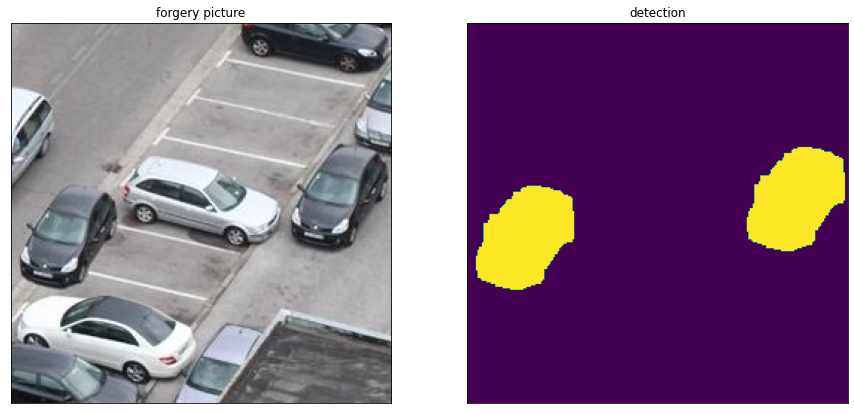

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
img = cv2.imread('input.png' , 0)
img1 = cv2.imread('input.png' , 1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
ax1.imshow(img1)
ax1.title.set_text('forgery picture')
ax1.set_xticks([])
ax1.set_yticks([])
height, width= img.shape
forgery = DetectionofCopyMoveForgery(img, height, width, 8,3.5,8,100,5)
detection_image = forgery.detection_forgery()
cv2.imwrite('output.png', detection_image)
ax2.imshow(detection_image)
ax2.title.set_text('detection')
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()